**ENGY-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2024; Prof. V. F. de Almeida

# Neutron Diffusion on a Spherical Domain
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
  \newcommand{\normal}{\boldsymbol{n}}
  \newcommand{\flux}{\boldsymbol{q}}
  \newcommand{\ihat}{\hat{\boldsymbol{i}}}
  \newcommand{\rhat}{\hat{\boldsymbol{r}}}
$

**Student: Melanie Breeze**  <br>
**Course:** ENGY-4390 Nuclear Systems Design and Analysis  <br>
**Advisor and Collaborator: Valmor F. de Almeida** 

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**16Dec2024**

## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Summary of Parameters](#parameters)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Boundary-Value Problem Statement](#p1)
* [Analytical Solution](#analyticalsolution)
* [Results](#res)
* [Conclusions](#conclusions)
* [References](#refs)
---

# [Introduction](#toc)<a id="intro"></a>

Neutron diffusion from a spherical source is a classical problem in neutron transport. This project investigates the solution of the source problem using 3 different approaches, namely the analyical solution, the finite element method using a Python implementation from the Engy-5330 course.
| |
|:---:|
| <img width="600" src="pics/domain.png" title="Domain"> |
| <p style="text-align:center;"><b>Domain of netron absorption: spherical annulus.</b></p> |

### Summary of Parameters

$$
\begin{aligned}
& \text {Table 1. Parameter summary}\\
&\begin{array}{l|c|r}
\hline \hline \text { Parameter } & \text { Definition } & \text { Units } \\
\hline
r & \text{Radius} & \mathrm{cm} \\
R & \text{Outer radius of region 1} & \mathrm{cm} \\
R_\infty & \text{Outer radius of region 2} & \mathrm{cm} \\
D & \text{Diffusion coefficient} & \mathrm{cm} \\
\Sigma_\mathrm{a} & \text{Macroscopic cross section} & \mathrm{cm^{-1}} \\
L & \text{Length term, } L = \sqrt{D/\Sigma_\mathrm{a}} & \mathrm{cm} \\
u & \text{Neutron spatial flux magnitude} & \mathrm{\#n\, cm^{-2}~s^{-1}} \\
q & \text{Neutron diffusion flux} & \mathrm{\#n\, cm^{-2}~s^{-1}} \\
s_0 & \text{Source term}& \mathrm{\#n\, cm^{-3}~s^{-1}} \\
c & \text{Constant of integration} & \mathrm{\# n\, cm^{-1}~s^{-1}} \\
A & \text{Surface area} & \mathrm{cm^2} \\
V & \text{Volume} & \mathrm{cm^3} \\
\hline
\end{array}
\end{aligned}
$$

## [Objectives](#toc)<a id="obj"></a>

 + Solve the 1-D, spherical coordinates, neutron diffusion from a point source problem using two regions.
   - Region 1 is the point source (a finite but very small radius)
   - Region 2 is the universe around the source (finite but very large to represent a boundless region)

This is old and needs revision
1. Gather Cross Section Data to provide study parameters
2. Set up two analytical solutions
    - Set up the non-asymptotic analytic solution __complete__  
    - Set up the asymptotic analytic solution with transient __almost complete__  
3. Code a MOOSE application to solve the neutron diffusion [problem](#strongform) using Galerkin's method with finite element basis functions
    - Set up spherical coordinate system: __complete__
    - Identify best test functions for problem domain: __unknown__  
    - "Absorption" term $\Sigma_{tot}\Phi $ is causing strong oscillations when included __unknown__  
    

## [Boundary-Value Problem Statement](#toc)<a id="p1"></a>

Solve the heterogeneous spatial neutron flux magnitude diffusion problem. Find the neutron spatial flux magnitude, $u_1:[0,R]\subset\Reals\rightarrow\Reals$, $u_2:[R,R_\infty]\subset\Reals\rightarrow\Reals$,
such that:


\begin{align*}
 -\frac{1}{r^2}\bigl(-D_1\, r^2 u_1'\bigr)'(r) - \Sigma_{a,1}\,u_1(r) + s_{0,1} &= 0 \quad\quad \forall \quad\quad r\in\ ]0,R[, \\
 -\frac{1}{r^2}\bigl(-D_2\, r^2 u_2'\bigr)'(r) - \Sigma_{a,2}\,u_2(r) + s_{0,2} &= 0 \quad\quad \forall \quad\quad r\in\ ]R,R_\infty[, \\
 q_{1,n}(0) &= 0, \\
 q_{2,n}(\infty) &= 0, \\
 u_1(R) &= u_2(R), \\
 q_{1,n}(R) &= q_{2,n}(R), \\
\end{align*}
   
Given data: diffusion coefficients, $D$, macroscopic absorption cross sections, $\Sigma_a$, source $s_0$, boundary conditions of normal diffusive flux, and continuity conditions at the interfaces (both normal diffusive flux and solution). Where $q_{i,n}(r) = \flux_{i}(r)\cdot\normal(r) = -D_i\,u_i'(r)\,\rhat \cdot \normal(r) \ \forall \ i=1,2$.

## [Analytical Solution](#toc)<a id="analyticalsolution"></a>
Each one of the neutron diffusion equations have an analytical solution, as follows:
\begin{align*}
-\frac{D_i}{r^2} \left(r^2 u_i^\prime\right)^\prime - \Sigma_{a,i}u_i + s_{0,i} &= 0 \qquad  i=1,2 , \\
\frac{1}{r}\left(r^2 u_i^\prime\right)^\prime -r\frac{\Sigma_{a,i}\,u_i}{D_i} &= - r\frac{s_{0,i}}{D_i}
\end{align*}

The latter are both in the form

\begin{align*}
y^{\prime\prime} + a y^\prime + by = R\left( x \right)
\end{align*}

with solution

\begin{align*}
y = c_1 e^{m_1x} + c_2 e^{m_2 x} 
    + \frac{e^{m_1x}}{m_1-m_2} \int R\left(x\right) e^{-m_1x} \, dx
    + \frac{e^{m_2x}}{m_2-m_1} \int R\left(x\right) e^{-m_2x} \, dx,
\end{align*}

where $a$ and $b$ are constants, and $m_1$ and $m_2$ are the real and distinct roots of $m^2+am+b=0$.

Thus, for $w_i=r\,u_i$, $a=0$, $b=-\frac{\Sigma_{a,i}}{D_i}$, $R=- r\frac{s_{0,i}}{D_i}$, and the roots are

\begin{align*}
m^2 - \frac{\Sigma_{a,i}}{D_i} = 0, \\ 
m = \pm \sqrt{\frac{\Sigma_{a,i}}{D_i}} = \pm \frac{1}{L_i}, \\
m_1 = \frac{1}{L_i}, \\ 
m_2 = -\frac{1}{L_i}
\end{align*}

Therefore

\begin{align*}
w_i = ru_i = c_{1,i}\, e^{r/L_i} + c_{2,i}\, e^{-r/L_i} 
             + \frac{e^{r/L_i}}{L_i^{-1}-(-L_i^{-1})} \int - \frac{s_{0,i}\,r}{D_i} e^{-r/L_i} \,dr 
             + \frac{e^{-r/L_i}}{-L_i^{-1}-L_i^{-1}} \int - \frac{s_{0,i}\,r}{D_i} e^{r/L_i} \,dr
\\
u_i = c_{1,i}\, \frac{e^{r/L_i}}{r} + c_{2,i}\, \frac{e^{-r/L_i}}{r} 
      - \frac{s_{0,i}\,L_i\,e^{r/L_i}}{2rD_i} \int r\, e^{-r/L_i} \, dr
      + \frac{s_{0,i}\,L_i\,e^{-r/L_i}}{2rD_i} \int r\, e^{r/L_i} \, dr
\end{align*}

Note that

\begin{align*}
\int r\, e^{-r/L_i} \, dr = - L_i\left(r + L_i\right)\,e^{-r/L_i},
\\
 \int r\, e^{-r/L_i} \, dr = L_i\left(r-L_i\right)\,e^{r/L_i},
\end{align*}

and upon substitution, the final 2 terms on the right side of the above formula for $u_i$ simplifies to

\begin{equation*}
\frac{s_{0,i}\,L_i^2}{D_i}.
\end{equation*}

Hence, finally:
\begin{align*}
\boxed{ u_i=c_{1,i} \, \frac{e^{r/L_i}}{r} + c_{2,i} \, \frac{e^{-r/L_i}}{r} + \frac{L_i^2 \, s_{0,i}}{D_i} },
\end{align*}

and

\begin{align*}
u_i^\prime = c_{1,i}\, \frac{e^{r/L_i}}{r}\left( \frac{1}{L_i} - \frac{1}{r} \right) 
           - c_{2,i}\, \frac{e^{-r/L_i}}{r}\left(\frac{1}{L_i} + \frac{1}{r} \right),
\end{align*}

or a better form for evaluating the derivative at $r=0$,

\begin{align*}
\boxed{ u_i^\prime = c_{1,i}\, \frac{e^{r/L_i}}{r^2}\left( \frac{r}{L_i} - 1 \right) 
           - c_{2,i}\, \frac{e^{-r/L_i}}{r^2}\left(\frac{r}{L_i} + 1 \right)}.
\end{align*}

## Boundary and Interface conditions

The boundary and interface conditions will define the coefficents of integration.

### For $u_1$

Then, taking the boundary condition $q_{n,1} = -D_1u_1^{\prime}(0) = 0$, that is, $u_1^{\prime}(0) = 0$, then from the formula above,

\begin{align*}
u_1^\prime(0) = 0 = \lim_{r=0} \frac{1}{r^2} \bigl( - c_{1,1}- c_{2,1} \bigr) = 0
\end{align*}

if and only if $c_{1,1} + c_{2,1} = 0$. Thus,

\begin{align*}
u_1 = c_{1,1} \frac{e^{r/L_1} - e^{-r/L_1}}{r} + \frac{L_1^2 s_{0,1}}{D_1} \tag{1-1}
\end{align*}

And

\begin{align*}
u_1^\prime = c_{1,1} \left[\frac{e^{r/L_1}}{r^2} \left(\frac{r}{L_1} - 1 \right) 
                        + \frac{e^{-r/L_1}}{r^2}\left(\frac{r}{L_1} + 1 \right) \right] \tag{1-2}
\end{align*}

### For $u_2$
Taking the boundary condition $q_{2,n}(\infty) = 0 = -D_2 \,u_2^\prime(\infty)$, hence

\begin{align*}
 u_2^\prime(\infty) = 0 = \lim_{r=\infty} \, c_{1,2} \frac{e^{r/L_2}}{r^2}\Bigl( \frac{r}{L_2} - 1 \Bigr) 
                                 - c_{2,2} \frac{e^{-r/L_2}}{r^2}\Bigl( \frac{r}{L_2} + 1 \Bigr)
\end{align*}

One obtains $c_{1,2} = 0$ resulting in

\begin{align*}
u_2 = c_{2,2} \, \frac{e^{-r/L_2}}{r} + \frac{L_2^2 \, s_{0,2}}{D_2} \tag{2-1}
\end{align*}

And
\begin{align*}
u_2^\prime = - c_{2,2}\, \frac{e^{-r/L_2}}{r^2}\Bigl(\frac{r}{L_2} + 1 \Bigr) \tag{2-2}
\end{align*}

### For $u_1$ and $u_2$
The innterface conditions are two, so the remaining constants, $c_{1,1}$ and $c_{2,2}$ can be found. 
First, the spatial neutron flux magnitude needs to matched at the interface $r=R$. That is, $u_1(R) = u_2(R)$, therefore

\begin{align}
\frac{c_{1,1}}{R} \left(e^{R/L_1} - e^{-R/L_1} \right) + \frac{L_1^2 s_{0,1}}{D_1} 
= 
c_{2,2} \, \frac{e^{-R/L_2}}{R} + \frac{L_2^2 \, s_{0,2}}{D_2} . \tag{3-1}
\end{align}

Second, continuity of the normal flux, $q_{1,n}(R) = q_{2,n}(R)$, and  this means that $D_1\,u_1^\prime(R)= D_2\,u_2^\prime(R)$, that is

\begin{align}
D_1\, c_{1,1} \biggl(\frac{e^{R/L_1}}{R^2}\left(\frac{R}{L_1} - 1 \right) 
                        + \frac{e^{-R/L_1}}{R^2}\left(\frac{R}{L_1} + 1 \right) \biggr)
=
- D_2\, c_{2,2}\, \frac{e^{-R/L_2}}{R^2}\left(\frac{R}{L_2} + 1 \right). \tag{3-2}
\end{align}

From this, the coupled equations arise

\begin{align}
 c_{1,1}\left(e^{R/L_1} - e^{-R/L_1} \right) - c_{2,2}e^{-R/L_2} 
&=  
 R\left( \frac{L_2^2 \, s_{0,2}}{D_2} - \frac{L_1^2 s_{0,1}}{D_1} \right).
\end{align}
\begin{align}
c_{1,1}D_1 \left[e^{R/L_1}\left(\frac{R}{L_1} - 1 \right) + e^{-R/L_1}\left(\frac{R}{L_1} + 1 \right) \right]  + c_{2,2} D_2 e^{-R/L_2}\left(\frac{R}{L_2} + 1 \right) 
&=
0
\end{align}

which can be solved analytically for $c_{1,1}$ and $c_{2,2}$. Or in matrix form



$$\begin{bmatrix}
e^{R/L_1} - e^{-R/L_1}  & - e^{-R/L_2}  \\
D_1 \left(e^{R/L_1}\left(\frac{R}{L_1} - 1 \right) + e^{-R/L_1}\left(\frac{R}{L_1} + 1 \right) \right) & D_2\, e^{-R/L_2}\left(\frac{R}{L_2} + 1 \right)
\end{bmatrix}
\,
\begin{bmatrix}
 c_{1,1} \\
 c_{2,2}
\end{bmatrix}
=
\begin{bmatrix}
R\left( \frac{L_2^2 \, s_{0,2}}{D_2} - \frac{L_1^2 s_{0,1}}{D_1} \right) \\
0
\end{bmatrix}
$$

## ["Point Source in an Infinite Domain"](#toc)<a id="inf-case"></a>

Consider an inner sphere source with a very small radius surrounded by annular region with a large radius. This scenario mimics the ideal point source case in an infinite domain. We cannot have a real infinite domain in a simulation, therefore a large outer radius will do it.

In [1]:
'''SI units'''
from scipy import constants as unit
unit.second = 1.0
unit.meter = 1.0
unit.cm = unit.centi*unit.meter
unit.mm = unit.milli*unit.meter
unit.um = unit.micro*unit.meter
unit.nm = unit.nano*unit.meter

In [2]:
'''Domain'''
import numpy as np

case = 'small'
assert case in ['small', 'large']

if case == 'large':
    r_0 = 0.5*unit.um
    r_R = 100*unit.cm
    r_oo = 300*unit.cm  # infinity
    [x_vec, u_n_vec, q_n_vec] = np.genfromtxt(fname='gold-data/100-300-neutron-ball-source-inf.txt') #larger r_R
elif case == 'small':
    r_0 = 0.5*unit.um
    r_R = 10*unit.cm
    r_oo = 100*unit.cm  # infinity
    [x_vec, u_n_vec, q_n_vec] = np.genfromtxt(fname='gold-data/10-100-neutron-ball-source-inf.txt') #smaller r_R

In [3]:
'''Domain'''
def show_domain(r_R, r_oo):
    import pyvista as pv
    pv.set_plot_theme('paraview')

    radius_i = r_R
    radius_o = r_oo
    outer = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_o)
    inner = pv.Sphere(center=(0,0,0), direction=(0,0,1), radius=radius_i)

    plo = pv.Plotter(notebook=True, shape=(1,1), off_screen=True) 
    plo.subplot(0,0)
    plo.add_mesh(outer, color='yellow', opacity=0.59,)
    plo.add_mesh(inner, color='red', opacity=1)
    plo.add_axes(xlabel='R', ylabel='Theta', zlabel='Phi')
    plo.screenshot('domain.png', window_size=(1000,400))
    plo.camera.zoom(1.8)
    cpos = plo.show(window_size=(1000, 400), auto_close=False)
    return plo

In [4]:
#plo = show_domain(r_R, r_oo)

In [5]:
# import matplotlib.pyplot as plt
# plt.figure(1, figsize=(100, 10))
# plt.imshow(plo.image)
# plt.show()

### [Data](#toc)<a id="data-sym"></a>

Solve problem with parameter values:

> + $R$, $V$, $q_{n \infty}$
> + $D_1$, $\Sigma_{a1}$, $s_{0,1}$
> + $D_2$, $\Sigma_{a2}$, $s_{0,2}$

### [Results](#toc)<a id="res"></a> 

In [6]:
'''Gathering variables'''
import math
import numpy as np
from scipy import constants as unit

# Source
diffusion_coeff_1 = 1.5*unit.cm
sigma_a_1 = 0.005/unit.cm
#source_1_dot = 1/unit.second
#volume = 4/3*math.pi*(r_R)**3
#source_1 = source_1_dot/volume
source_1 = 1e5/unit.cm**3/unit.second

l_1 = (diffusion_coeff_1/sigma_a_1)**0.5

# Right side material
diffusion_coeff_2 = 1.0*unit.cm
sigma_a_2 = 0.01/unit.cm
source_2 = 0./unit.cm**3/unit.second
l_2 = (diffusion_coeff_1/sigma_a_1)**0.5

# normal flux
q_noo = 0.0*unit.cm**2/unit.second

In [7]:
'''Matrix solution'''
#u_1
a_11 = np.e**(r_R/l_1) - np.e**(- r_R/l_1) 
a_12 = -np.e**(-r_R/l_2)

a_21 = diffusion_coeff_1 * ( np.e**(r_R/l_1) * (1/l_1 - 1/r_R) +  np.e**(-r_R/l_1) * ( 1/l_1 + 1/r_R) )
a_22 = diffusion_coeff_2 * np.e**(-r_R/l_2) * (1/l_2 + 1/r_R) 

mtrx_a = np.array([[a_11, a_12],
                  [a_21, a_22]])

#units: [ s^{-1} * cm^{-2}]
y_1 = source_1*(l_1**2)/diffusion_coeff_1
y_2 = source_2*(l_2**2)/diffusion_coeff_2

rightside = r_R* (y_2 - y_1)
vec_y = np.array([rightside,0])

from scipy.linalg import solve
[c_1,c_2] = solve(mtrx_a,vec_y) #units: [#n cm^{-1}~s^{-1}]

In [8]:
'''Functions'''
def u_1(r):
    '''Values of u_1 over distance r'''     
    return (c_1/r)* (np.e**(r/l_1) - np.e**(-r/l_1))  + y_1

def u_2(r):
    '''Values of u_2 over distance r'''
    return (c_2/r)* np.e**(-r/l_2)  + y_2

def q_1(r):
    '''Flux of region 1 over distance r'''
    return - c_1* diffusion_coeff_1 * ( np.e**(r/l_1) *(1/(l_1*r) - r**-2)  + np.e**(-r/l_1) * ( 1/(l_1*r) + r**-2) )

def q_2(r):
    '''Flux of region 2 over distance r'''
    return c_2* diffusion_coeff_2 *np.e**(-r/l_2) * ( 1/(l_1*r) + r**-2) 

## Note:
As shown below, both the neutron spatial flux magnitude $u_1$ and the diffusive flux $q_1$ near the origin has flucutations due to truncation error and evaluation of the analytical formulae. Therefore the comparison to numerical results should be done at a safe distance from the origin. Also, the boundary condition applied on the numerical method should be applied not at the origin but at a safe distance (see companion numerical notebook). Here we will pick 0.5 um as the lower limit of the radial direction.

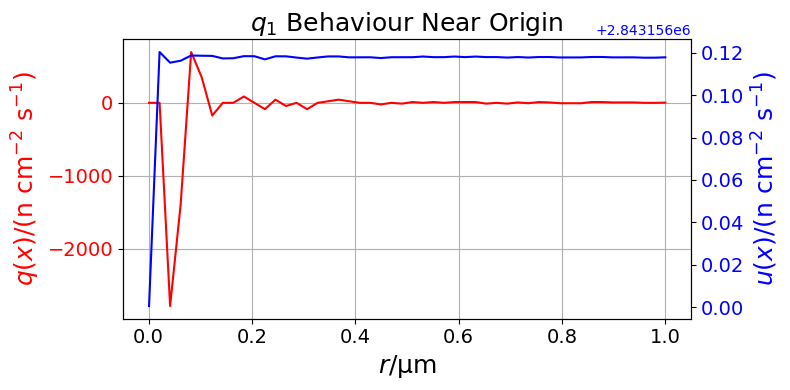

In [16]:
import matplotlib.pyplot as plt
(fig, ax1) = plt.subplots(1, figsize=(8, 4))

x = np.linspace(1*unit.nm, 1*unit.um, 50)

ax1.plot(x/unit.um, q_1(x)*unit.cm**2*unit.second, 'r-')

ax1.set_xlabel(r'$r/\mathrm{\mu m}$', fontsize=18)
ax1.set_ylabel(r'$q(x)/(\mathrm{n~ cm^{-2}~s^{-1}})$', fontsize=18, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
#ax1.set_ylim(0,1)
ax1.grid(True)

# create a twin x axis to be shared
ax2 = ax1.twinx()

ax2.plot(x/unit.um, u_1(x)*unit.cm**2*unit.second, 'b-')

ax2.set_ylabel(r"$u(x)/(\mathrm{n~ cm^{-2}~s^{-1}})$", fontsize=18, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=14)
#ax2.set_ylim(0,2)
#ax2.grid(True)

plt.title(r'$q_1$ Behaviour Near Origin', fontsize=18)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [10]:
print('u_1(0.5 um) [#n cm^-2 s^-1] = ', u_1(0.5*unit.um)*unit.cm**2*unit.second)
print('q_1(0.5 um) [#n cm^-2 s^-1] = ', q_1(0.5*unit.um)*unit.cm**2*unit.second)

u_1(0.5 um) [#n cm^-2 s^-1] =  2843156.1179289585
q_1(0.5 um) [#n cm^-2 s^-1] =  0.0


In [11]:
print('u_num(0.5 um) [#n cm^-2 s^-1] = ', u_n_vec[0]*unit.cm**2*unit.second)
print('q_num(0.5 um) [#n cm^-2 s^-1] = ', q_n_vec[0]*unit.cm**2*unit.second)

u_num(0.5 um) [#n cm^-2 s^-1] =  2496564.0
q_num(0.5 um) [#n cm^-2 s^-1] =  1.4141590000000002


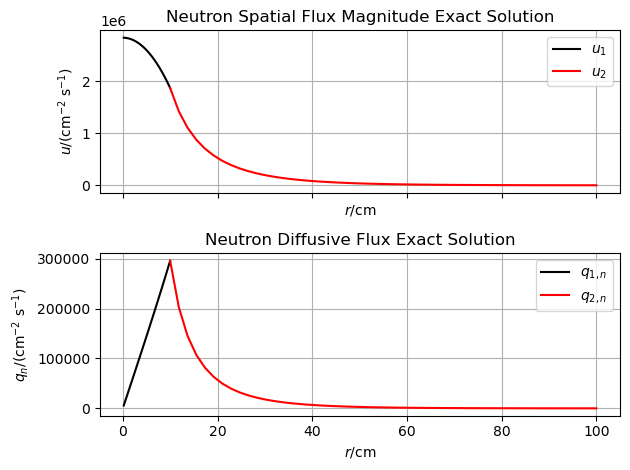

In [12]:
'''Plotting'''
import matplotlib.pyplot as plt

r_range_1 = np.linspace(r_0, r_R)[1:]
r_range_2 = np.linspace(r_R, r_oo)

fig, ax = plt.subplots(2,1, sharex=True, tight_layout=True)
ax[0].errorbar(x = r_range_1/unit.cm, y = u_1(r_range_1)/(unit.cm**-2 * unit.second**-1), label = r'$u_1$',
            color = 'k')
ax[0].errorbar(x = r_range_2/unit.cm, y = u_2(r_range_2)/(unit.cm**-2 * unit.second**-1), label = r'$u_2$',
            color = 'r')
ax[0].set_xlabel(r'$r/\mathrm{cm}$')
ax[0].set_ylabel(r'$u/(\mathrm{n~cm^{-2}~s^{-1}})$')
ax[0].legend()
ax[0].set_title('Neutron Spatial Flux Magnitude Exact Solution')
ax[0].grid(True)

ax[1].errorbar(x = r_range_1/unit.cm, y = q_1(r_range_1)/(unit.cm**-2 * unit.second**-1), label = r'$q_{1,n}$',
            color = 'k')
ax[1].errorbar(x = r_range_2/unit.cm, y = q_2(r_range_2)/(unit.cm**-2 * unit.second**-1), label = r'$q_{2,n}$',
            color = 'r')
ax[1].set_xlabel(r'$r/\mathrm{cm}$')
ax[1].set_ylabel(r'$q_n/(\mathrm{cm^{-2}~s^{-1}})$')
ax[1].legend()
ax[1].set_title('Neutron Diffusive Flux Exact Solution')
ax[1].grid(True)
plt.show()

## Comparison to numerical

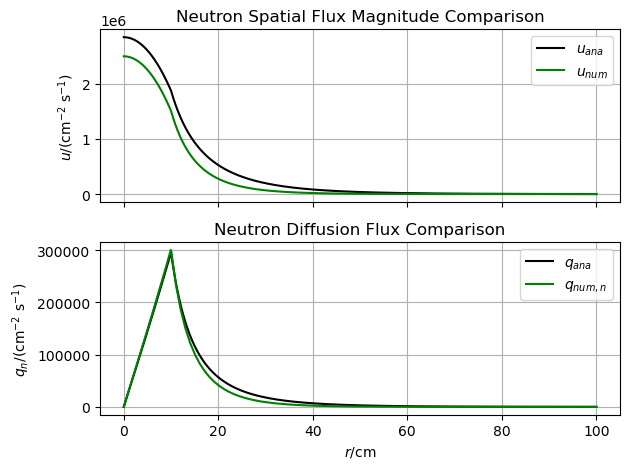

In [13]:
r = x_vec

'''Combined forms of u and q'''
r_1 = np.where(r <= r_R)[0]
r_2 = np.where(r > r_R)[0]
u_12 = np.append(u_1(r[r_1]), u_2(r[r_2]))
q_12 = np.append(q_1(r[r_1]), q_2(r[r_2]))

fig, ax = plt.subplots(2, sharex=True,tight_layout=True)

ax[0].plot(r/unit.cm, u_12/(unit.cm**-2 * unit.second**-1), label = r'$u_{ana}$', color = 'k')
ax[0].plot(r/unit.cm, u_n_vec/(unit.cm**-2 * unit.second**-1), label = r'$u_{num}$', color = 'g')

# ax[0,0].set_xlabel(r'$r/\mathrm{cm}$')
ax[0].set_ylabel(r'$u/(\mathrm{cm^{-2}~s^{-1}})$')
ax[0].legend()
ax[0].set_title('Neutron Spatial Flux Magnitude Comparison')
ax[0].grid(True)

ax[1].plot(r/unit.cm, q_12/(unit.cm**-2 * unit.second**-1), label = r'$q_{ana}$', color = 'k')
ax[1].plot(r/unit.cm, q_n_vec/(unit.cm**-2 * unit.second**-1), label = r'$q_{num,n}$',color = 'g')

ax[1].set_xlabel(r'$r/\mathrm{cm}$')
ax[1].set_ylabel(r'$q_n/(\mathrm{cm^{-2}~s^{-1}})$')
ax[1].legend()
ax[1].set_title('Neutron Diffusion Flux Comparison')
ax[1].grid(True)

plt.plot()
plt.show()

## Relative Percent Error in the 1 cm to 50 cm range

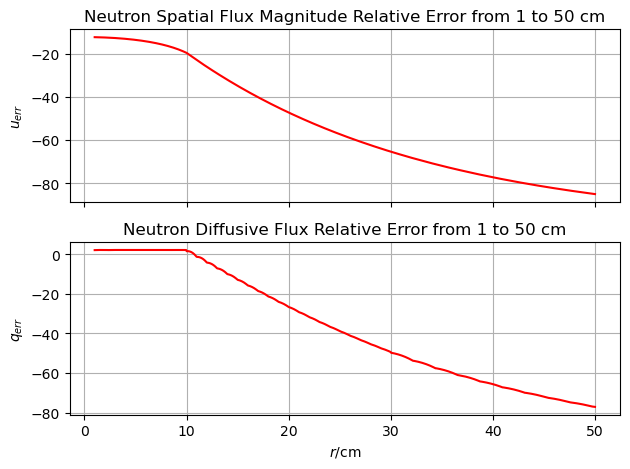

Average error: u_{err,avg} = -52.581, q_{err,avg} = -36.558


In [14]:
start = np.where( r >= 1*unit.cm)[0][0]
end = np.where( r <= 50*unit.cm)[0][-1]

uerr = (u_n_vec[start:end+1] - u_12[start:end+1])/u_12[start:end+1]*100

qerr = (q_n_vec[start:end+1] - q_12[start:end+1])/q_12[start:end+1]*100

fig, ax = plt.subplots(2, sharex=True, tight_layout=True)

ax[0].plot(r[start:end+1]/unit.cm, uerr, color = 'r')
# ax[0,1].set_xlabel(r'$r/\mathrm{cm}$')
ax[0].set_ylabel(r'$u_{err}$')
ax[0].grid(True)
ax[0].set_title('Neutron Spatial Flux Magnitude Relative Error from 1 to 50 cm')

ax[1].plot(r[start:end+1]/unit.cm, qerr, color = 'r')
ax[1].set_xlabel(r'$r/\mathrm{cm}$')
ax[1].set_ylabel(r'$q_{err}$')
ax[1].grid(True)
ax[1].set_title('Neutron Diffusive Flux Relative Error from 1 to 50 cm')

plt.plot()
plt.show()

print(r'Average error: u_{err,avg} = %3.5g, q_{err,avg} = %3.5g' %(np.average(uerr), np.average(qerr)))
# plt.savefig('./pics/uq_numer_analyt_compare.png')

## [Conclusions](#toc)<a id="conclusions"></a>

The aforementioned errors are significant. for both cases, *small* and *large* sphere. The analytical solution cannot be directly evaluated at the origin. It needs special care of the limit of the radial position at zero. Also away from zero, there is a fluctuation that needs to be avoided as demonstrated above. One idea is to redo the numerical solution using the value of $u_1$ at a safe distance from the origin as a Dirichlet boundary condition. This will certainly have a much better result; a future investigation.

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5330: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] V. F. de Almeida, [*Engy-5050: Nuclear Reactor Physics: Neutron Diffusion from a Point Source*](https://nbviewer.org/github/dpploy/engy-5050/blob/main/notebooks/03-diff-point-source.ipynb), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).